In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
import sklearn.ensemble
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix
from inspect import signature

from sklearn.preprocessing import label_binarize

from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from scipy import interp
from itertools import cycle
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB

### Load the Training Data

In [2]:
inputData = pd.read_csv('trainData_set1.csv')

#### Replace Upcylce and Downcycle to Up and Down in the Indicative Tick Direction Column

In [3]:
inputData.TICKDIR.describe()

count     52396
unique        5
top        FLAT
freq      47029
Name: TICKDIR, dtype: object

In [4]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN          1685
DOWNCYCLE     1163
FLAT         47029
UP            1665
UPCYCLE        854
Name: TIME, dtype: int64

In [5]:
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('UPCYCLE', 'UP')
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('DOWNCYCLE', 'DOWN')

In [6]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN     2848
FLAT    47029
UP       2519
Name: TIME, dtype: int64

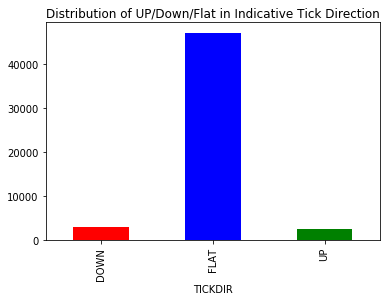

In [7]:
subset.plot(kind='bar', title='Distribution of UP/Down/Flat in Indicative Tick Direction',
           color=['red','blue','green']);

#### Extract a single feature - bid ask imbalance

In [8]:
# extracting a single feature
X = inputData.BIDASKIMBALANCE

#### Reshaping X as it has only one feature

In [9]:
X = np.array(X).reshape(-1,1)

In [10]:
X.shape

(52396, 1)

### Multi Classification 

#### Converting the Indicative Tick Direction to numerical format

In [11]:
y = inputData.TICKDIR.replace('UP', 1)
y = y.replace('FLAT', 0)
y = y.replace('DOWN', -1)

In [12]:
y.shape

(52396,)

#### Train test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

#### Learn to predict each class against the other

In [14]:
classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=500)

In [15]:
y_score = classifier.fit(X_train, y_train)

#### Classifying by Random Forest and Gradient Boosting

In [16]:
y_score = classifier.predict_proba(X_test)

In [17]:
y_pred = classifier.predict(X_test)

In [18]:
#y_score = y_score[:,1]

In [19]:
y_score[0]

array([0., 1., 0.])

#### Plot Distribution of the Prediction

In [20]:
prediction = pd.DataFrame({'prediction': y_pred})
prediction1 = prediction.reset_index()
summary = prediction1.groupby(by='prediction').count()
summary

index
prediction       
-1            317
 0           4689
 1            234

In [21]:
actual = pd.DataFrame({'actual': y_test})
actualreset = actual.reset_index()
summary1 = actualreset.groupby(by='actual').count()
summary1

index
actual       
-1        281
 0       4706
 1        253

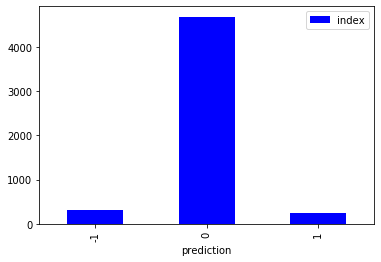

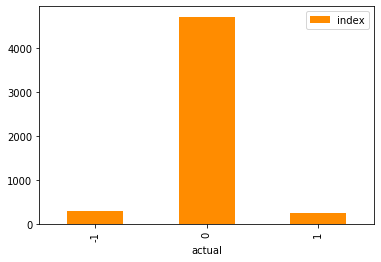

In [22]:
prediction = pd.DataFrame({'prediction': y_pred})
prediction1 = prediction.reset_index()
summary = prediction1.groupby(by='prediction').count()
summary.plot(kind='bar', color='blue');

actual = pd.DataFrame({'actual': y_test})
actualreset = actual.reset_index()
summary1 = actualreset.groupby(by='actual').count()
summary1.plot(kind='bar', color='darkorange');

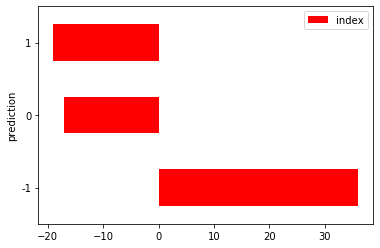

In [23]:
summary2 = summary - summary1
#for p in ax.patches:
#    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
summary2.plot(kind='barh', color='red');

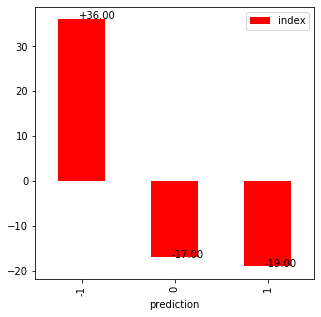

In [24]:
ax = summary2.plot(kind='bar', color='red', figsize=(5,5))
x_offset = -0.03
y_offset = 0.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:+.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

In [25]:
y_score[0:15]

array([[0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.092, 0.908, 0.   ],
       [0.   , 0.338, 0.662],
       [0.012, 0.988, 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 0.972, 0.028],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 0.246, 0.754]])

In [26]:
y_score[:15,2]

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.662, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.028, 0.   , 0.   , 0.754])

In [27]:
localPredict = []

for i,j,k in zip(y_score[:,0], y_score[:,1], y_score[:,2]):
    
    if i > 0.23:
        predict = -1
        localPredict.append(predict)
    
    elif k > 0.25:
        predict = 1
        localPredict.append(predict)
        
    else:
        predict = 0
        localPredict.append(predict)

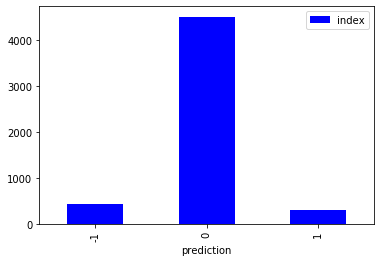

In [28]:
localPrediction = pd.DataFrame({'prediction': localPredict})
localPrediction1 = localPrediction.reset_index()
summary3 = localPrediction1.groupby(by='prediction').count()
summary3.plot(kind='bar', color='blue');

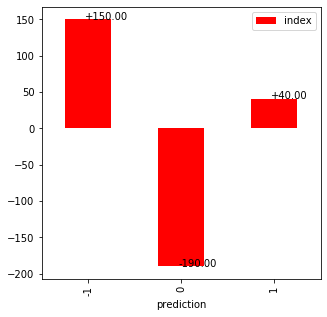

In [29]:
summary4 = summary3 - summary1
ax = summary4.plot(kind='bar', color='red', figsize=(5,5))
x_offset = -0.03
y_offset = 0.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:+.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

#### Accuracy Score

In [30]:
accuracy_score(y_test, y_pred)

0.8681297709923664

In [31]:
accuracy_score(y_test, localPredict)

0.8553435114503817

#### Confusion Matrix

In [32]:
confusion_matrix(y_test, y_pred)

array([[  96,  181,    4],
       [ 219, 4355,  132],
       [   2,  153,   98]])

In [33]:
y_test.shape

(5240,)

In [34]:
confusion_matrix(y_test, localPredict)

array([[ 131,  146,    4],
       [ 298, 4235,  173],
       [   2,  135,  116]])

#### Classification Report

#### Precision:
- The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
- The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

- The best value is 1 and the worst value is 0.

#### Recall:
- The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
- The recall is intuitively the ability of the classifier to find all the positive samples.

- The best value is 1 and the worst value is 0.

#### F-1 Score:
- The F1 score can be interpreted as a weighted average of the precision and recall.
- An F1 score reaches its best value at 1 and worst score at 0.
- The relative contribution of precision and recall to the F1 score are equal.
- F1 = 2 x (precision x recall) / (precision + recall)

In [35]:
print(classification_report(y_test, y_pred, labels=[-1,0,1]))

              precision    recall  f1-score   support

          -1       0.30      0.34      0.32       281
           0       0.93      0.93      0.93      4706
           1       0.42      0.39      0.40       253

    accuracy                           0.87      5240
   macro avg       0.55      0.55      0.55      5240
weighted avg       0.87      0.87      0.87      5240



In [36]:
print(classification_report(y_test, localPredict, labels=[-1,0,1]))

              precision    recall  f1-score   support

          -1       0.30      0.47      0.37       281
           0       0.94      0.90      0.92      4706
           1       0.40      0.46      0.42       253

    accuracy                           0.86      5240
   macro avg       0.55      0.61      0.57      5240
weighted avg       0.88      0.86      0.87      5240

